In [10]:
import re
import json
import matplotlib.pyplot as plt
import dataclasses
import os
import numpy as np

In [25]:
BASIC_LOG_PATTERN = re.compile(
    r"EvaluationResult\(seed=(\d+),\s+"
    r"cumulative_reward=([\d.]+),\s+"
    r"time_within_radius=([\d.]+),\s+"
    r"out_of_power=(\w+),\s+"
    r"final_timestep=(\d+)\)"
)
SAFETY_LAYER_PATTERNS = [
    r'Power safety layer violations: (\d+)',
    r'Altitude safety layer violations: (\d+)',
    r'Envelope safety layer violations: (\d+)'
]

@dataclasses.dataclass
class EvalResult:
    reward: float
    twr: float
    out_of_power: bool
    final_timestep: int
    power_safety_layer_violations: int = 0
    altitude_safety_layer_violations: int = 0
    envelope_safety_layer_violations: int = 0


def get_metrics_from_output(filepath):
    rewards = {}
    last_seed = None
    with open(filepath, "r") as f:
        for line in f:
            regex_match = BASIC_LOG_PATTERN.search(line)
            
            # read the basic log data
            if regex_match:
                seed, cumulative_reward, time_within_radius, out_of_power, final_timestep = regex_match.groups()

                seed = int(seed)
                rewards[seed] = EvalResult(float(cumulative_reward), float(time_within_radius), out_of_power=="True", float(final_timestep))
                last_seed = seed

            # check for safety layer violations
            elif last_seed is not None:
                for pattern in SAFETY_LAYER_PATTERNS:
                    match = re.search(pattern, line)
                    if match:
                        violation_count = int(match.group(1))
                        if "Power" in pattern:
                            rewards[last_seed].power_safety_layer_violations = violation_count
                        elif "Altitude" in pattern:
                            rewards[last_seed].altitude_safety_layer_violations = violation_count
                        elif "Envelope" in pattern:
                            rewards[last_seed].envelope_safety_layer_violations = violation_count
    return rewards

def get_metrics_from_outputs(filepaths):
    all_rewards = {}
    for filepath in filepaths:
        rewards = get_metrics_from_output(filepath)
        for seed, result in rewards.items():
            if seed in all_rewards:
                print("Unexpected seed collision, seed:", seed)
            all_rewards[seed] = result
    return all_rewards

def get_saved_result(foldername):
    filepath = 'saved_results/' + foldername
    # Get all filenames in the filepath
    filenames = [f for f in os.listdir(filepath) if os.path.isfile(os.path.join(filepath, f))]

    # get metrics from files    
    metrics = get_metrics_from_outputs([os.path.join(filepath, filename) for filename in filenames if filename.endswith('.err')])

    # find description.txt file if it exists
    description_file = os.path.join(filepath, 'description.txt')
    if os.path.isfile(description_file):
        with open(description_file, 'r') as f:
            description = f.read()
    else:
        description = "No description file found."
    
    return description, metrics



In [30]:
saved_results_names = ['mpc4_agent-0', 'mpc4_agent-1', 'mpc4_agent-2', 'mpc4_agent-3', 'perciatelli-0', 'perciatelli-1', 'perciatelli-2' ]
saved_results = {}

for saved_result_name in saved_results_names:
    description, metrics = get_saved_result(saved_result_name)
    description = description.replace('\n', ' ; ')
    print(f"Description for {saved_result_name}: {description}")
    saved_results[saved_result_name] = metrics
    

Description for mpc4_agent-0: basic power cost and basic modelling of power safety layer inside dynamics (that was acutally more restrictive)
Description for mpc4_agent-1: basic safety features (same as mpc4_Agent-0) but  ; with q function terminal cost
Description for mpc4_agent-2: mpc agent without any safety features or power cost ; with q function
Description for mpc4_agent-3: gd steps 200 with learning rate of 0.1 with no q function  ; do not believe there is q function here ; run on FEW seeds
Description for perciatelli-0: No description file found.
Description for perciatelli-1: perciatelli without any safety layers
Description for perciatelli-2: No description file found.


In [31]:
def get_common_seeds(metrics):
    common_seeds = None
    for result in metrics:
        if common_seeds is None:
            common_seeds = set(result.keys())
        else:
            common_seeds.intersection_update(set(result.keys()))
    return common_seeds

def get_average_metrics(metrics):
    seeds = get_common_seeds(metrics)

    report = []
    for metric in metrics:
        avg_reward = np.mean([metric[seed].reward for seed in seeds])
        avg_twr = np.mean([metric[seed].twr for seed in seeds])
        avg_out_of_power = np.mean([metric[seed].out_of_power for seed in seeds])
        avg_final_timestep = np.mean([metric[seed].final_timestep for seed in seeds])
        avg_power_safety_layer_violations = np.mean([metric[seed].power_safety_layer_violations for seed in seeds])
        avg_altitude_safety_layer_violations = np.mean([metric[seed].altitude_safety_layer_violations for seed in seeds])
        avg_envelope_safety_layer_violations = np.mean([metric[seed].envelope_safety_layer_violations for seed in seeds])

        report.append(EvalResult(
            reward=avg_reward,
            twr=avg_twr,
            out_of_power=avg_out_of_power,
            final_timestep=avg_final_timestep,
            power_safety_layer_violations=avg_power_safety_layer_violations,
            altitude_safety_layer_violations=avg_altitude_safety_layer_violations,
            envelope_safety_layer_violations=avg_envelope_safety_layer_violations
        ))
        
    return report

In [37]:
get_average_metrics([ saved_results['mpc4_agent-3'], saved_results['perciatelli-1'] ])

[EvalResult(reward=401.3278704446808, twr=0.24625000000000002, out_of_power=0.0, final_timestep=960.0, power_safety_layer_violations=0.0, altitude_safety_layer_violations=0.0, envelope_safety_layer_violations=0.0),
 EvalResult(reward=436.908420832711, twr=0.3357291666666667, out_of_power=0.0, final_timestep=960.0, power_safety_layer_violations=17.0, altitude_safety_layer_violations=0.0, envelope_safety_layer_violations=0.0)]

In [7]:
def get_results_on_seeds(metrics, seeds):
    results = {}
    for seed in seeds:
        if seed not in metrics:
            print("Missing seed:", seed)
            continue
        result = metrics[seed]
        if result.out_of_power:
            print("Unexpected out of power on ", seed)
            continue
        results[seed] = result
    return results

common_seeds = set(full_perciatelli_metrics.keys()).intersection(set(full_mpc_metrics.keys()))

perciatelli_metrics = get_results_on_seeds(full_perciatelli_metrics, common_seeds)
mpc_metrics = get_results_on_seeds(full_mpc_metrics, common_seeds)



perciatelli_average_twr = sum([metrics.twr for metrics in perciatelli_metrics.values()]) / len(perciatelli_metrics)
print(f"perciatelli Average TWR: {perciatelli_average_twr}")
mpc_average_twr = sum([metrics.twr for metrics in mpc_metrics.values()]) / len(mpc_metrics)
print(f"mpc Average TWR: {mpc_average_twr}")

mpc_std_twr = np.std([metrics.twr for metrics in mpc_metrics.values()])
print(f"mpc Std TWR: {mpc_std_twr}")
perciatelli_std_twr = np.std([metrics.twr for metrics in perciatelli_metrics.values()])
print(f"perciatelli Std TWR: {perciatelli_std_twr}")

z = 1.96
mpc_twr_confidence_interval = (mpc_average_twr - z * mpc_std_twr / np.sqrt(len(mpc_metrics)), mpc_average_twr + z * mpc_std_twr / np.sqrt(len(mpc_metrics)))
print(f"mpc TWR 95% confidence interval: {mpc_twr_confidence_interval}")
perciatelli_twr_confidence_interval = (perciatelli_average_twr - z * perciatelli_std_twr / np.sqrt(len(perciatelli_metrics)), perciatelli_average_twr + z * perciatelli_std_twr / np.sqrt(len(perciatelli_metrics)))
print(f"perciatelli TWR 95% confidence interval: {perciatelli_twr_confidence_interval}")

# calculate necessary trials to have 95% confidence interval of 0.01
E = 0.05
mpc_n = (z * mpc_std_twr / E) ** 2
perciatelli_n = (z * perciatelli_std_twr / E) ** 2
print(f"mpc necessary trials: {mpc_n}")
print(f"perciatelli necessary trials: {perciatelli_n}")



perciatelli Average TWR: 0.29356562499999933
mpc Average TWR: 0.3267614583333337
mpc Std TWR: 0.3056883801566619
perciatelli Std TWR: 0.2953809805795746
mpc TWR 95% confidence interval: (0.30781469623670127, 0.34570822042996613)
perciatelli TWR 95% confidence interval: (0.27525772214794114, 0.3118735278520575)
mpc necessary trials: 143.59191757855487
perciatelli necessary trials: 134.07172273616044


219 deltas are 0.0
431 deltas are positive
350 deltas are negative


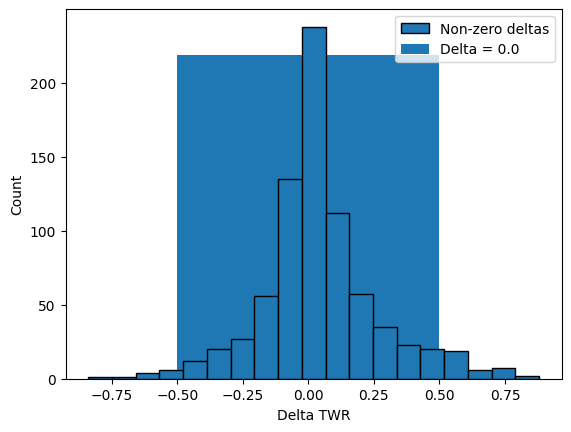

In [17]:
perciatelli_twrs = np.array([metrics.twr for metrics in perciatelli_metrics.values()])
mpc_twrs = np.array([metrics.twr for metrics in mpc_metrics.values()])

delta_twrs = mpc_twrs - perciatelli_twrs

zero_deltas = delta_twrs[np.isclose(delta_twrs, 0.0)]
nonzero_deltas = delta_twrs[~np.isclose(delta_twrs, 0.0)]

print(len(zero_deltas), "deltas are 0.0")
print(len([delta for delta in nonzero_deltas if delta > 0.0 ]), "deltas are positive")
print(len([delta for delta in nonzero_deltas if delta < 0.0]), "deltas are negative")

# plot
fig, ax = plt.subplots()

# first, plot the 0.0s manually
ax.bar(0.0, len(zero_deltas), width=1.0, label='Delta = 0.0')

# then plot the non-zero deltas with a histogram
bins = np.linspace(np.min(nonzero_deltas), np.max(nonzero_deltas), 20)  # or whatever number of bins you want
ax.hist(nonzero_deltas, bins=bins, edgecolor='black', label='Non-zero deltas')

ax.set_xlabel('Delta TWR')
ax.set_ylabel('Count')
ax.legend()
plt.show()

seed=0  , prci=0.56875, mpc4=0.63750, score=1.12088
seed=1  , prci=0.00000, mpc4=0.00000, score=0.00000/0.0
seed=2  , prci=0.30625, mpc4=0.21979, score=0.71769
seed=3  , prci=1.00000, mpc4=1.00000, score=1.00000
seed=4  , prci=1.00000, mpc4=0.99271, score=0.99271
seed=5  , prci=0.62396, mpc4=0.81875, score=1.31219
seed=6  , prci=0.03958, mpc4=0.37917, score=9.57895
seed=7  , prci=0.31146, mpc4=0.43542, score=1.39799
seed=8  , prci=0.99167, mpc4=0.87396, score=0.88130
seed=9  , prci=0.02396, mpc4=0.08438, score=3.52174
seed=10 , prci=0.03438, mpc4=0.21563, score=6.27273
seed=11 , prci=0.00000, mpc4=0.62187, score=0.62187/0.0
seed=12 , prci=0.02292, mpc4=0.06146, score=2.68182
seed=13 , prci=0.26979, mpc4=0.20000, score=0.74131
seed=14 , prci=0.08646, mpc4=0.09792, score=1.13253
seed=15 , prci=0.58021, mpc4=0.50833, score=0.87612
seed=16 , prci=0.00000, mpc4=0.00000, score=0.00000/0.0
seed=17 , prci=0.11354, mpc4=0.21354, score=1.88073
seed=18 , prci=0.00000, mpc4=0.00000, score=0.00000/

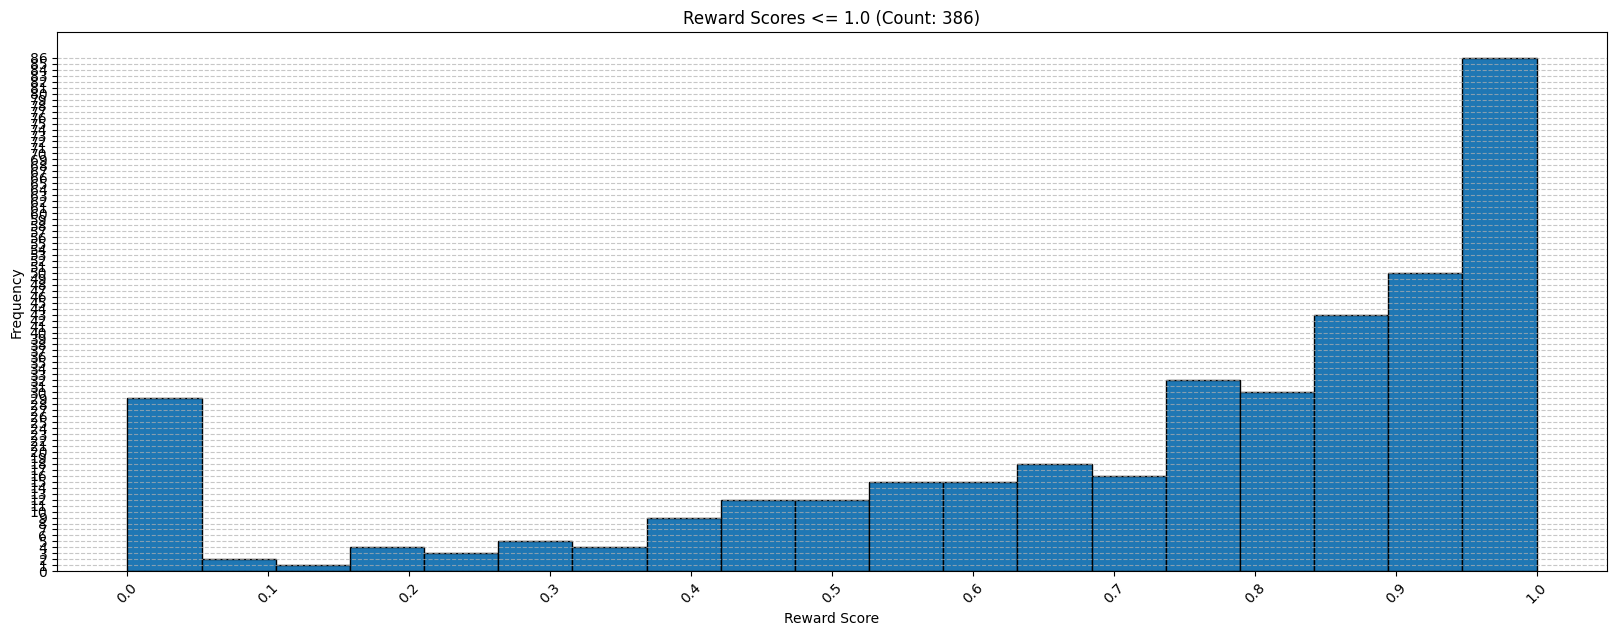

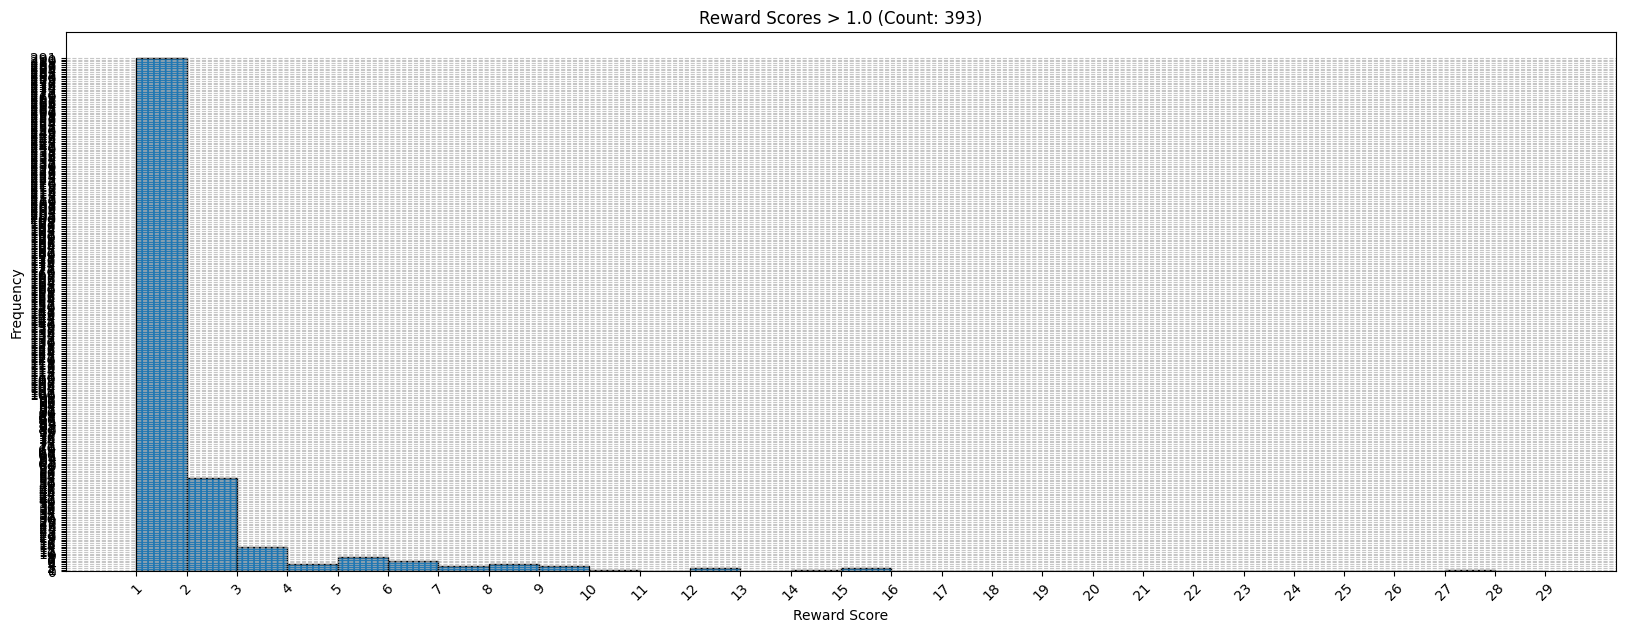

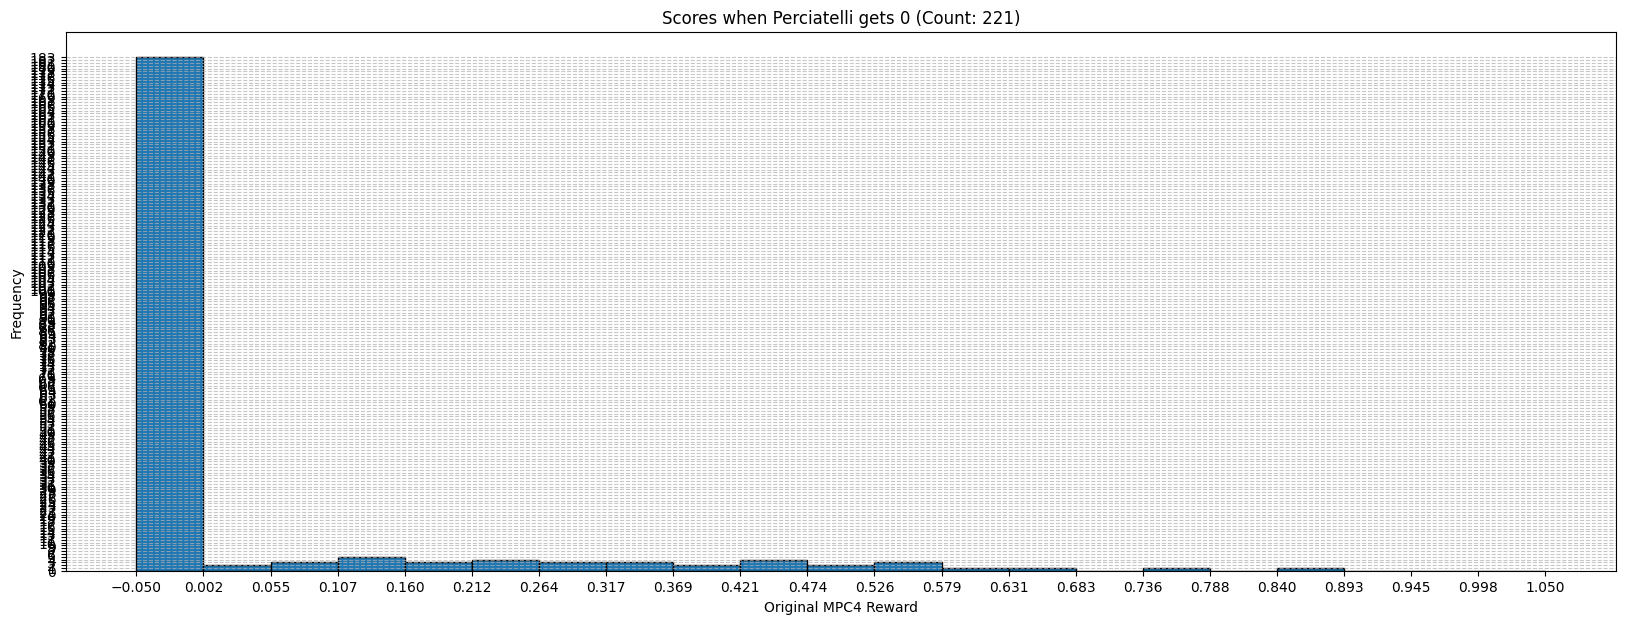

In [68]:
perciatelli_non_zero_count = 0
mpc4_non_zero_count = 0

reward_scores = []

for seed in common_seeds:
    if seed in perciatelli_metrics and perciatelli_metrics[seed].twr > 0:
        perciatelli_non_zero_count += 1

    if seed in mpc_metrics and mpc_metrics[seed].twr > 0:
        mpc4_non_zero_count += 1

    if seed in mpc_metrics and seed in perciatelli_metrics:        
        perciatelli_reward = perciatelli_metrics[seed].twr
        mpc4_reward = mpc_metrics[seed].twr

        seed_repr = str(seed) + (3 - len(str(seed))) * ' '

        if perciatelli_reward == 0:
            reward_score = -1.0 - mpc4_reward
            reward_scores.append(reward_score)
            print(f"seed={seed_repr}, prci={perciatelli_reward:.5f}, mpc4={mpc4_reward:.5f}, score={mpc4_reward:.5f}/0.0")
        else:
            reward_score  = mpc4_reward / perciatelli_reward
            reward_scores.append(reward_score)
            print(f"seed={seed_repr}, prci={perciatelli_reward:.5f}, mpc4={mpc4_reward:.5f}, score={reward_score:.5f}")
    else:
        print('skipping seed', seed)

scores_below_one = [score for score in reward_scores if 0.0 <= score <= 1.0]
scores_above_one = [score for score in reward_scores if score > 1.0]
negative_scores = [score for score in reward_scores if score < 0.0]

plt.figure(figsize=(20, 7))
bins_below_one = np.linspace(0.0, 1.0, 20)
plt.hist(scores_below_one, bins=bins_below_one, edgecolor='black')
plt.xticks(np.linspace(0.0, 1.0, 11), rotation=45)
plt.yticks(range(0, max(np.histogram(scores_below_one, bins=bins_below_one)[0]) + 1))
plt.title(f"Reward Scores <= 1.0 (Count: {len(scores_below_one)})")
plt.xlabel("Reward Score")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Plot scores above 1.0
plt.figure(figsize=(20, 7))
bins_above_one = np.arange(1.0, max(scores_above_one) + 2, 1.0)
plt.hist(scores_above_one, bins=bins_above_one, edgecolor='black')
plt.xticks(np.arange(1.0, max(scores_above_one) + 2, 1.0), rotation=45)
plt.yticks(range(0, max(np.histogram(scores_above_one, bins=bins_above_one)[0]) + 1))
plt.title(f"Reward Scores > 1.0 (Count: {len(scores_above_one)})")
plt.xlabel("Reward Score")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Plot negative scores (original mpc4 rewards)
plt.figure(figsize=(20, 7))
negative_scores = -(np.array(negative_scores) + 1)
bins_negative = np.linspace(0.0, 1.1, 22) - 1.1/22
plt.hist(negative_scores, bins=bins_negative, edgecolor='black')
plt.xticks(bins_negative)
plt.yticks(range(0, max(np.histogram(negative_scores, bins=bins_negative)[0]) + 1))
plt.title(f"Scores when Perciatelli gets 0 (Count: {len(negative_scores)})")
plt.xlabel("Original MPC4 Reward")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()